In [14]:
from collections import defaultdict
from Bio.SeqIO.FastaIO import SimpleFastaParser as sfp
from concurrent.futures import ProcessPoolExecutor
from Bio import SeqIO, SearchIO, Entrez
import seaborn as sns
import pandas as pd
import os, glob, math, re, gzip, skbio, time, pysam, time
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import warnings
import numpy as np
from Bio import Entrez
warnings.filterwarnings('ignore')

In [15]:
import sys
sys.path.insert(0, '/home/users/ajaffe/notebooks/modules/')
import parse

In [16]:
def cmdir(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def scaffold(gene):
    if gene != "None":
        try: return re.search("(.+?)_[0-9]+$", gene).group(1)
        except: print(gene)

def sbatch(name, cpus, cmd):
    return "sbatch -J %s -p serc -t 1- -c %d --mem %dG --wrap '%s'" %(name, cpus, cpus*8, cmd)

In [17]:
rootdir = "/scratch/users/ajaffe/photoeco/"
deepeco = "/scratch/users/ajaffe/deepeco/"
cmdir(rootdir + "txomics")

## prep

In [5]:
# write to snakefile config
with open(rootdir + "txomics/config.yaml", "w") as out:
    
    out.write("fasta: %s\n" %(rootdir + "diversity/nonredundant_genomes.fna"))
    out.write("stbfile: %s\n" %(rootdir + "diversity/nonredundant_genomes.stb"))
    out.write("idx: %s\n" %(rootdir + "diversity/nr_genomes.idx"))

In [6]:
# write new genome table
with open(rootdir + "txomics/photoeco_genome_table.tsv", "w") as out:
    out.write("genome\n")
    stb = pd.read_csv(rootdir + "diversity/nonredundant_genomes.stb", sep="\t")
    stb.columns = ["scaffold", "bin"]
    for genome in stb["bin"].unique():
        out.write(genome + "\n")

### get input samples

In [11]:
Entrez.email = "ajaffe@stanford.edu"

In [ ]:
with open(rootdir + "txomics/sample_list.tsv", "w") as out:
    for line in open(deepeco + "txomics/mapping/sample_list.tsv").readlines():
        sample = line.strip().split("\t")[0]
        if sample in ["ETNP_7T_105m", "TARA_SAMEA2622149_METAT"]:
            out.write("%s\t%s\n" %(sample, line.strip().split("\t")[1]))

In [13]:
query = '(METATRANSCRIPTOMIC[Source]) AND ("Eastern Tropical North Pacific" OR "oxygen deficient zone" OR "oxygen minimum zone")'
handle = Entrez.esearch(db='sra', term=query, RetMax=20000)
# parse the handle
soup = BeautifulSoup(handle, "html.parser")
handle.close()
# then grab the uIds
sra_ids = [item.string for item in soup.findAll("id")]
len(sra_ids)

81

In [14]:
results = defaultdict(list)

for i,sra_id in enumerate(sra_ids):
    
    try:
        handle = Entrez.efetch(db="sra", id=sra_id, rettype="runinfo", retmode="xml")
        soup = BeautifulSoup(handle, "html.parser")
        handle.close()
    except:
        print("%s failed." %(sra_id))
        continue

    for row in soup.findAll("row"):
        for attribute in ["bases","bioproject", "biosample", "experiment", "run", "libraryname", "samplename",
                          "scientificname", "releasedate", "spots",  
                        "avglength", "librarystrategy", "librarysource", "librarylayout","platform"]:
            try:
                results[attribute].append(row.find(attribute).string)
            except: results[attribute].append("None")
    
    print("%d of %d done." %(i+1, len(sra_ids)), end = "\r")
    
    time.sleep(1)

In [15]:
resultdf = pd.DataFrame(results).query("librarysource=='METATRANSCRIPTOMIC'").query("bioproject=='PRJNA727903'")

with open(rootdir + "txomics/sample_list.tsv", "a") as out:
    for key, row in resultdf.iterrows():
        out.write("%s\t%s\n" %(row["samplename"].replace(">",""), row["run"]))

### run + check

In [18]:
cmd = 'snakemake --keep-going -s RNASnakefile \
      --config sample_list=%s genome_table=%s maxthreads=20 \
      --cluster "sbatch -p serc -c 20 -t 1- --mem 160G" --jobs 20' %(rootdir + "txomics/sample_list.tsv",
                                                                     rootdir + "txomics/photoeco_genome_table.tsv")
print(cmd)

snakemake --keep-going -s RNASnakefile       --config sample_list=/scratch/users/ajaffe/photoeco/txomics/sample_list.tsv genome_table=/scratch/users/ajaffe/photoeco/txomics/photoeco_genome_table.tsv maxthreads=20       --cluster "sbatch -p serc -c 20 -t 1- --mem 160G" --jobs 20


## process

In [18]:
def filter_sample(output_file):
    
    start=time.time()
    filtered_results = []
    sample_table = pd.read_csv(output_file, sep="\t")
    
    for genome in sample_table["genome"].unique():
        
        subtable = sample_table[sample_table["genome"]==genome]
        
        # min gene expressed threshold
        if len(subtable.query("breadth>0.50"))>=50:
        
            # then remove high outliers
            genes_to_remove = []
            counts = subtable["mean_coverage"].to_list()
            median = np.median([count for count in counts if count != 0])

            for i, count in enumerate(counts):
                if count > (median*10000):
                    genes_to_remove.append(subtable["gene"].to_list()[i])
            
            filtered_results.append(subtable[~subtable["gene"].isin(genes_to_remove)])
            
    end = time.time()
    #print("%s finished in %f seconds." %(os.path.basename(output_file), end-start))
    
    if len(filtered_results) > 0:
        return pd.concat(filtered_results)
    else: return "None"

In [19]:
%%time

with ProcessPoolExecutor(10) as executor:
    samples = glob.glob(rootdir + "txomics/output/*tsv")
    results = list(executor.map(filter_sample, samples))

all_results = pd.concat([result for result in results if type(result) != str])
all_results = all_results[["sample", "genome", "gene", "mean_coverage", "breadth", "read_count", "read_count_or"]]
all_results.to_csv(rootdir + "txomics/filtered_txome_output.tsv", sep="\t")

CPU times: user 811 ms, sys: 227 ms, total: 1.04 s
Wall time: 16.6 s


### calculate rpkm

In [20]:
tmp = {}
stb = pd.read_csv(rootdir + "diversity/nonredundant_genomes.stb", sep="\t")
stb.columns = ["scaffold", "bin"]

for genome in stb["bin"].unique():
    gpath = rootdir + "genomes/filtered/%s.genes.fna" %(genome)
    for record in sfp(open(gpath)):
        tmp[record[0].split(" ")[0]] = len(record[1])

all_results["gene_length"] = all_results["gene"].map(tmp)
tmp={}

In [21]:
tmp = {}

for sample in glob.glob(rootdir + "txomics/trimmed_reads/counts/*"):
    for line in open(sample).readlines():
        tmp[line.split("\t")[0]] = int(line.split("\t")[1].strip())

all_results["total_read_count"] = all_results["sample"].map(tmp)
tmp = {}

In [22]:
# consider rewriting this in dask
all_results["rpk"] = all_results.apply(lambda x: (x["read_count"])/(x["gene_length"]/1000), axis=1)
all_results["rpkm"] = all_results.apply(lambda x: x["rpk"]/(x["total_read_count"]/1e6), axis=1)
all_results["rpko"] = all_results.apply(lambda x: (x["read_count_or"])/(x["gene_length"]/1000), axis=1)
all_results["rpkmo"] = all_results.apply(lambda x: x["rpko"]/(x["total_read_count"]/1e6), axis=1)
all_results.head(2)

,sample,genome,gene,mean_coverage,breadth,read_count,read_count_or,gene_length,total_read_count,rpk,rpkm,rpko,rpkmo
0,304427_S16,SRR11923207.100.13,SRR11923207.100.13_scaffold_0_1,0.00,0.000000,0,0,1068,59911104,0.000000,0.000000,0.000000,0.000000
1,304427_S16,SRR11923207.100.13,SRR11923207.100.13_scaffold_0_2,0.08,0.079422,2,1,1662,59911104,1.203369,0.020086,0.601685,0.010043


## add back function

In [27]:
cmdir(rootdir + "protein")

In [23]:
genomes = pd.read_csv(rootdir + "genome_table.tsv", sep="\t")
genomes.head(2)

,genome_name,lineage,checkm_completeness,checkm_redundancy,cluster95,cluster99
0,2626541517,AMZ IB,56.79,6.11,5_1,5_5
1,2626541518,AMZ IB,60.34,6.90,5_1,5_10


In [29]:
# create fasta, genes, stb for nr db
faa = open(rootdir + "protein/nonredundant_genomes.faa", "w")

for cluster in genomes["cluster95"].unique():

    table = genomes[genomes["cluster95"]==cluster].sort_values("checkm_completeness", ascending=False)
    representative = table["genome_name"].iloc[0]

    faapath = glob.glob(rootdir + "genomes/filtered/" + representative + ".genes.faa")[0]
    
    for record in sfp(open(faapath)):
        faa.write(">%s\n%s\n" %(record[0].split(" ")[0], record[1]))

faa.close()

### kofam

In [31]:
#kofam
kocall = "exec_annotation -o %s %s -p %s -k %s --cpu 20 -f detail" \
    %(rootdir + "protein/nonredundant_genomes.kfscan.txt",
      rootdir + "protein/nonredundant_genomes.faa",
     "/home/groups/dekas/software/kofamscan/profiles/prokaryote.hal",
      "/home/groups/dekas/software/kofamscan/ko_list")
print(sbatch("kfscan", 20, kocall))

sbatch -J kfscan -p serc -t 1- -c 20 --mem 160G --wrap 'exec_annotation -o /scratch/users/ajaffe/photoeco/protein/nonredundant_genomes.kfscan.txt /scratch/users/ajaffe/photoeco/protein/nonredundant_genomes.faa -p /home/groups/dekas/software/kofamscan/profiles/prokaryote.hal -k /home/groups/dekas/software/kofamscan/ko_list --cpu 20 -f detail'


In [24]:
kresults = parse.kofamscan(rootdir + "/protein/nonredundant_genomes.kfscan.txt", 1e-20)
kresults.head(2)

,gene,ko,threshold,score,eval,def
1182565,Ga0132167_11_1503,K00284,2197.70,2262.1,0.0,glutamate synthase (ferredoxin) [EC:1.4.7.1]
1007050,Ga0132163_11_1583,K00284,2197.70,2260.2,0.0,glutamate synthase (ferredoxin) [EC:1.4.7.1]


### pfam

In [32]:
#pfam
cmd = "hmmsearch --cpu 20 --domtblout %s /oak/stanford/groups/dekas/db/Pfam-A.hmm %s" %(rootdir + "protein/nonredundant_genomes.pfam.txt",
                                                                               rootdir + "protein/nonredundant_genomes.faa")
print(sbatch("pfam", 20, cmd))

sbatch -J pfam -p serc -t 1- -c 20 --mem 160G --wrap 'hmmsearch --cpu 20 --domtblout /scratch/users/ajaffe/photoeco/protein/nonredundant_genomes.pfam.txt /oak/stanford/groups/dekas/db/Pfam-A.hmm /scratch/users/ajaffe/photoeco/protein/nonredundant_genomes.faa'


In [25]:
## subset pfam for now - taking too long to parse
reps = []

with open(rootdir + "protein/AMZ_names.txt", "w") as out:
    
    out.write("#\n")
    
    for cluster in genomes["cluster95"].unique():

        table = genomes[genomes["cluster95"]==cluster].sort_values("checkm_completeness", ascending=False)
        representative = table["genome_name"].iloc[0]

        if table["lineage"].iloc[0] in ["AMZ IA", "AMZ IB"]:
            
            reps.append(representative)
            faapath = glob.glob(rootdir + "genomes/filtered/" + representative + ".genes.faa")[0]
            
            for record in sfp(open(faapath)):
                out.write(record[0].split(" # ")[0] + "\n")

In [26]:
pfam = parse.domtable(rootdir + "protein/AMZ_genomes.pfam.txt")
pfam = pfam.query("eval<1e-20").query("hmm_overall_cov>0.50")

pfam_info = defaultdict(list)

for gene in pfam["gene"].unique():
    pfams = pfam[pfam["gene"]==gene]["hmm"].to_list()
    evals = pfam[pfam["gene"]==gene]["eval"].to_list()
    pfam_info["gene"].append(gene)
    pfam_info["pfams"].append(" + ".join(pfams))
    pfam_info["highest_eval"].append(max(evals))

pfam_df = pd.DataFrame(pfam_info)
pfam_df.head(2)

,gene,pfams,highest_eval
0,SRR12424656.100.10_scaffold_0_37,2-Hacid_dh + 2-Hacid_dh_C + PGDH_inter,1.400000e-25
1,SRR11923207.100.13_scaffold_8_26,2-Hacid_dh + 2-Hacid_dh_C + PGDH_inter,8.500000e-26


### integrate

In [27]:
rubiscos = pd.read_csv(rootdir + "rubisco_table.tsv", sep="\t")
rep_results = all_results[all_results["genome"].isin(reps)]
rep_results = rep_results.merge(kresults[["gene", "ko", "def"]], on="gene", how="left").fillna("None")
rep_results = rep_results.merge(pfam_df[["gene", "pfams"]], how="left", on="gene").fillna("None")
rep_results = rep_results.merge(rubiscos[["gene", "hmm"]], how="left", on="gene").fillna("None")
rep_results = rep_results[["sample", "genome", "gene", "mean_coverage", "read_count", "breadth", "rpkm", "rpkmo", "ko", "def", "pfams", "hmm"]]
rep_results.columns = ["sample", "genome", "gene", "mean_coverage", "read_count", "breadth", "rpkm", "rpkmo", "ko", "ko_def", "pfams", "rubisco"]
rep_results.head()

,sample,genome,gene,mean_coverage,read_count,breadth,rpkm,rpkmo,ko,ko_def,pfams,rubisco
0,304427_S16,SRR11923207.100.13,SRR11923207.100.13_scaffold_0_1,0.00,0,0.000000,0.000000,0.000000,None,None,None,None
1,304427_S16,SRR11923207.100.13,SRR11923207.100.13_scaffold_0_2,0.08,2,0.079422,0.020086,0.010043,None,None,DUF3370,None
2,304427_S16,SRR11923207.100.13,SRR11923207.100.13_scaffold_0_3,0.00,0,0.000000,0.000000,0.000000,K03090,RNA polymerase sigma-B factor,None,None
3,304427_S16,SRR11923207.100.13,SRR11923207.100.13_scaffold_0_4,0.00,0,0.000000,0.000000,0.000000,K00988,sulfate adenylyltransferase (ADP) / ATP adenyl...,Ap4A_phos_N,None
4,304427_S16,SRR11923207.100.13,SRR11923207.100.13_scaffold_0_5,0.00,0,0.000000,0.000000,0.000000,K06381,stage II sporulation protein D,SpoIID,None


In [28]:
calvin = []

for key, row in pd.read_csv("/scratch/users/ajaffe/deepeco/tables/kegg_table.tsv", sep="\t").iterrows():
    for gene in row["ko"].split(","):
        calvin.append(gene)

calvin[0:3]

['K00855', 'K01602', 'K00927']

In [29]:
def reconcile_functions(row):
    
    if row["rubisco"] == "I":
        return "form I rubisco"
    elif row["pfams"] == "RuBisCO_small":
        return "form I rubisco"
    elif row["rubisco"] == "II":
        return "form II rubisco"
    elif "Cso" in row["pfams"]:
        return "carboxysomal shell proteins"
    elif "subunit ribosomal protein" in row["ko_def"]:
        return "ribosomal proteins"
    elif row["ko"] in calvin:
        return "cbb cycle"
    elif row["ko"] == 'K03321':
        return "bicarbonate transporter"
    else: return "other"
    
rep_results["reconciled_function"] = rep_results.apply(reconcile_functions, axis=1)
rep_results["reconciled_function"].value_counts()

reconciled_function
other                          61335
ribosomal proteins              1305
cbb cycle                        270
bicarbonate transporter           45
carboxysomal shell proteins       45
form I rubisco                    45
form II rubisco                   15
Name: count, dtype: int64

## plot

In [30]:
transect = pd.read_csv(rootdir + "mra_table1.csv")
transect["station"] = transect["CTD cast; station"].apply(lambda x: x.split(";")[1].strip())
# trim some samples to reduce redundancy / nightime
transect = transect[~transect["Metatranscriptome"].isin(["304426_S15", "304421_S10", "304424_S13",
                                                        "304425_S14", "304419_S8", "304413_S2",
                                                         "304417_S6", "304418_S7"])]
transect = transect.rename(columns={"Metatranscriptome": "sample", "Sample typea":"sample_type"})
transect.sort_values("station")

,sample,SRA accession no.,BioSample no.,CTD cast; station,Collection date (yr-mo-day),Collection time (UTC)a,Local collection time (UTC-6)a,Depth (m),DO (µM),sample_type,No. of spots (reads),No. of bases,station
8,304420_S9,SRR14460573,SAMN19065212,59; P1,4/21/18,15:35,9:35,77.0,0.66,SCM,"22,226,093","6,667,827,900",P1
10,304422_S11,SRR14460585,SAMN19065214,63; P1,4/23/18,14:00,8:00,40.0,8.60,Low DO,"25,320,982","7,596,294,600",P1
11,304423_S12,SRR14460584,SAMN19065215,64; P1,4/24/18,14:03,8:03,126.0,1.00,Nitrite max,"25,828,575","7,748,572,500",P1
15,304427_S16,SRR14460580,SAMN19065219,72; P1,4/27/18,9:42,3:42,28.0,33.00,High DO,"30,533,274","9,159,982,200",P1
0,304412_S1,SRR14460587,SAMN19065204,43; P2,4/15/18,14:59,8:59,76.0,16.00,High DO,"27,597,785","8,279,335,500",P2
2,304414_S3,SRR14460579,SAMN19065206,46; P2,4/17/18,15:01,9:01,81.0,4.30,Low DO,"20,038,590","6,011,577,000",P2
3,304415_S4,SRR14460578,SAMN19065207,48; P2,4/18/18,15:01,9:01,150.0,0.60,Nitrite max,"28,017,373","8,405,211,900",P2
4,304416_S5,SRR14460577,SAMN19065208,49; P2,4/18/18,22:01,16:01,106.0,1.00,SCM,"25,854,483","7,756,344,900",P2


In [46]:
palette = {"form II rubisco": "#F7A616", "form I rubisco": "#008000", "bicarbonate transporter": "lightblue",
           "carboxysomal shell proteins": "#909EC6", "cbb cycle": "#D98DBF", "ribosomal proteins": "#7DBFA6"}

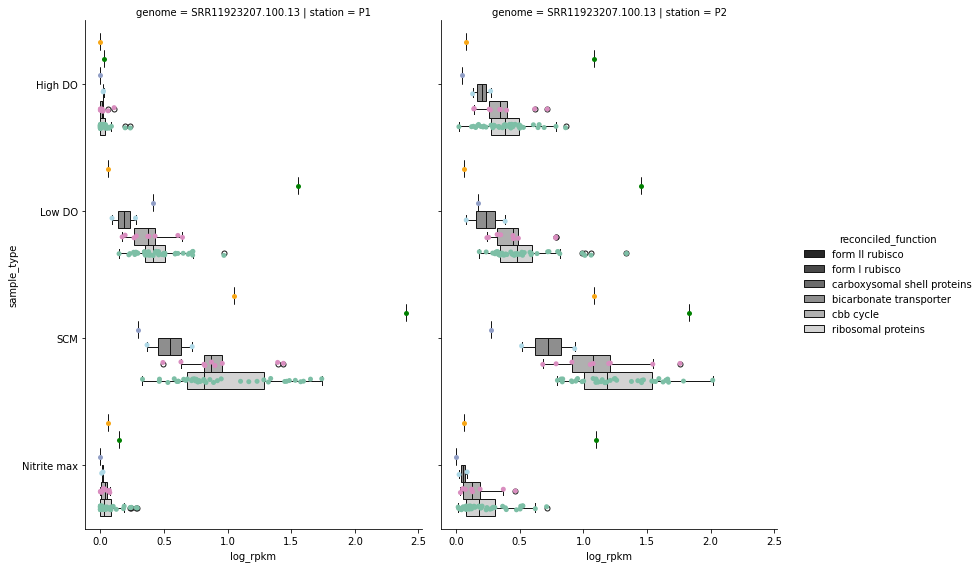

In [72]:
presults = rep_results[rep_results["sample"].isin(transect["sample"].to_list())]
presults = presults.merge(transect[["sample", "station", "sample_type"]], how="left")
presults["log_rpkm"] = presults["rpkmo"].apply(lambda x: math.log10(x+1))

g = sns.catplot(data=presults.query("genome=='SRR11923207.100.13'"), 
            x="log_rpkm", y="sample_type", kind="box", row="genome", col="station",
            hue_order = ["form II rubisco", "form I rubisco", "carboxysomal shell proteins",
                        "bicarbonate transporter", "cbb cycle", "ribosomal proteins"], color="lightgrey",
            hue="reconciled_function", dodge=True,order=["High DO", "Low DO", "SCM", "Nitrite max"],
           height=8, aspect=0.7)
g.map_dataframe(sns.stripplot, x="log_rpkm", y="sample_type", 
                hue_order = ["form II rubisco", "form I rubisco", "carboxysomal shell proteins",
                        "bicarbonate transporter", "cbb cycle", "ribosomal proteins"], palette=palette,
                hue="reconciled_function", dodge=True)
plt.savefig(rootdir + "txomics/txomics.svg", format="svg")
plt.show()

In [73]:
presults.to_csv(rootdir + "supp/txome_data.tsv", sep="\t", index=False)